In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [97]:
pd.set_option('display.max_columns', 90)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [98]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'
# path = '/GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis'
# /GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis
# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [99]:
train.sample()

,Provider,PotentialFraud
5134,PRV57424,No


In [100]:
print(inpatient.shape)
inpatient.sample()

(40474, 30)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
3762,BENE24503,CLM32009,2009-01-02,2009-01-05,PRV52990,12000,PHY373793,PHY335760,NaN,2009-01-02,7213,1068.0,2009-01-05,544,72402,V4582,25000,4589,4019,2768,78057,34931,2555,NaN,309.0,NaN,NaN,NaN,NaN,NaN


In [101]:
print(outpatient.shape)
outpatient.sample()

(517737, 27)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
64496,BENE29358,CLM734121,2009-12-18,2009-12-18,PRV52788,10,PHY313705,NaN,NaN,78900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [102]:
print(bene.shape)
bene.sample()

(138556, 25)


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
10468,BENE22200,1918-05-01,NaN,1,1,0,14,989,12,12,2,1,2,2,2,2,1,1,2,2,2,0,0,160,20


In [103]:
df = inpatient.groupby('Provider').agg(
    IPInscClaimAmtReimbursedCount = ('InscClaimAmtReimbursed', 'count'),
    IPInscClaimAmtReimbursedStd = ('InscClaimAmtReimbursed', 'std'),
    IPInscClaimAmtReimbursedMax = ('InscClaimAmtReimbursed', 'max')
).reset_index()
df

,Provider,IPInscClaimAmtReimbursedCount,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedMax
0,PRV51001,5,18352.111595,42000
1,PRV51003,62,8513.606244,57000
2,PRV51007,3,3511.884584,10000
3,PRV51008,2,12020.815280,21000
4,PRV51011,1,NaN,5000
...,...,...,...,...
2087,PRV57719,4,25350.871122,57000
2088,PRV57728,1,NaN,6000
2089,PRV57729,11,7226.214903,24000
2090,PRV57732,11,4742.458127,17000


In [104]:
print(df.shape)
df.sample()

(2092, 4)


,Provider,IPInscClaimAmtReimbursedCount,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedMax
1051,PRV54335,19,6085.64604,25000


In [105]:
out_df = outpatient.groupby('Provider').agg(
    OPInscClaimAmtReimbursedCount = ('InscClaimAmtReimbursed', 'count'),
    OPInscClaimAmtReimbursedStd = ('InscClaimAmtReimbursed', 'std'),
    OPInscClaimAmtReimbursedMax = ('InscClaimAmtReimbursed', 'max')
).reset_index()
out_df

,Provider,OPInscClaimAmtReimbursedCount,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedMax
0,PRV51001,20,422.817617,1500
1,PRV51003,70,821.364579,3300
2,PRV51004,149,689.963754,3300
3,PRV51005,1165,491.556392,4080
4,PRV51007,69,447.231657,3300
...,...,...,...,...
5007,PRV57759,28,820.880286,3300
5008,PRV57760,22,309.998254,1100
5009,PRV57761,82,418.366092,2200
5010,PRV57762,1,NaN,1900


In [106]:
provider_claims = pd.merge(
    df,
    out_df,
    on='Provider',
    how='outer',
).fillna(0)

In [107]:
print(provider_claims.shape)
provider_claims.sample(6)

(5410, 7)


,Provider,IPInscClaimAmtReimbursedCount,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedMax,OPInscClaimAmtReimbursedCount,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedMax
2565,PRV54196,0.0,0.000000,0.0,10.0,816.439424,2600.0
2657,PRV54308,0.0,0.000000,0.0,1.0,0.000000,70.0
4031,PRV56041,0.0,0.000000,0.0,55.0,925.036973,3300.0
3404,PRV55266,9.0,1666.666667,7000.0,16.0,429.959300,1700.0
1706,PRV53129,3.0,28354.893758,57000.0,43.0,246.994335,1000.0
2035,PRV53540,0.0,0.000000,0.0,13.0,312.479743,1000.0


In [108]:
provider_claims['Provider'].nunique()

5410

In [ ]:
# # Save selected columns to CSV
# provider_claims.to_csv('9 draft.csv', index=False)

In [109]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)

In [82]:
final_df

,Provider,IPInscClaimAmtReimbursedCount,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedMax,OPInscClaimAmtReimbursedCount,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedMax,PotentialFraud
0,PRV51001,5.0,18352.111595,42000.0,20.0,422.817617,1500.0,No
1,PRV51003,62.0,8513.606244,57000.0,70.0,821.364579,3300.0,Yes
2,PRV51004,0.0,0.000000,0.0,149.0,689.963754,3300.0,No
3,PRV51005,0.0,0.000000,0.0,1165.0,491.556392,4080.0,Yes
4,PRV51007,3.0,3511.884584,10000.0,69.0,447.231657,3300.0,No
...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,0.0,28.0,820.880286,3300.0,No
5406,PRV57760,0.0,0.000000,0.0,22.0,309.998254,1100.0,No
5407,PRV57761,0.0,0.000000,0.0,82.0,418.366092,2200.0,No
5408,PRV57762,0.0,0.000000,0.0,1.0,0.000000,1900.0,No


In [83]:
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPInscClaimAmtReimbursedCount,IPInscClaimAmtReimbursedStd,IPInscClaimAmtReimbursedMax,OPInscClaimAmtReimbursedCount,OPInscClaimAmtReimbursedStd,OPInscClaimAmtReimbursedMax,PotentialFraud
0,PRV51001,5.0,18352.111595,42000.0,20.0,422.817617,1500.0,0
1,PRV51003,62.0,8513.606244,57000.0,70.0,821.364579,3300.0,1
2,PRV51004,0.0,0.000000,0.0,149.0,689.963754,3300.0,0
3,PRV51005,0.0,0.000000,0.0,1165.0,491.556392,4080.0,1
4,PRV51007,3.0,3511.884584,10000.0,69.0,447.231657,3300.0,0
...,...,...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,0.0,28.0,820.880286,3300.0,0
5406,PRV57760,0.0,0.000000,0.0,22.0,309.998254,1100.0,0
5407,PRV57761,0.0,0.000000,0.0,82.0,418.366092,2200.0,0
5408,PRV57762,0.0,0.000000,0.0,1.0,0.000000,1900.0,0


In [84]:
final_df.columns

Index(['Provider', 'IPInscClaimAmtReimbursedCount',
       'IPInscClaimAmtReimbursedStd', 'IPInscClaimAmtReimbursedMax',
       'OPInscClaimAmtReimbursedCount', 'OPInscClaimAmtReimbursedStd',
       'OPInscClaimAmtReimbursedMax', 'PotentialFraud'],
      dtype='object')

In [85]:
X = final_df[['IPInscClaimAmtReimbursedCount',
       'IPInscClaimAmtReimbursedStd', 'IPInscClaimAmtReimbursedMax',
       'OPInscClaimAmtReimbursedCount', 'OPInscClaimAmtReimbursedStd',
       'OPInscClaimAmtReimbursedMax']]

In [86]:
y = final_df['PotentialFraud']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [88]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [89]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [90]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)
y_proba = model.predict_proba(X_test)[:, 1] # Outputs predicted class labels (0 or 1)


In [91]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[962  15]
 [ 61  44]]


In [92]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.75
Recall: 0.42
F1 Score: 0.54


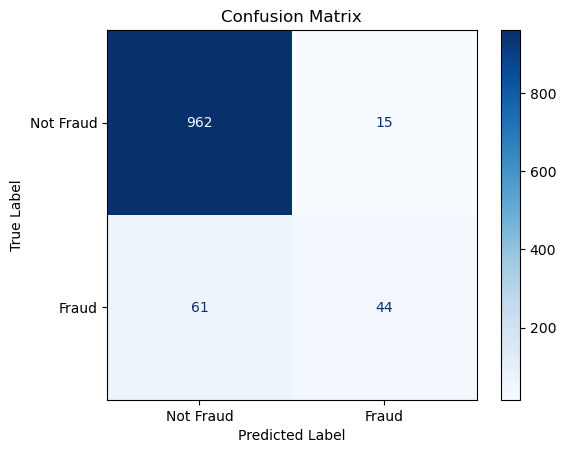

In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

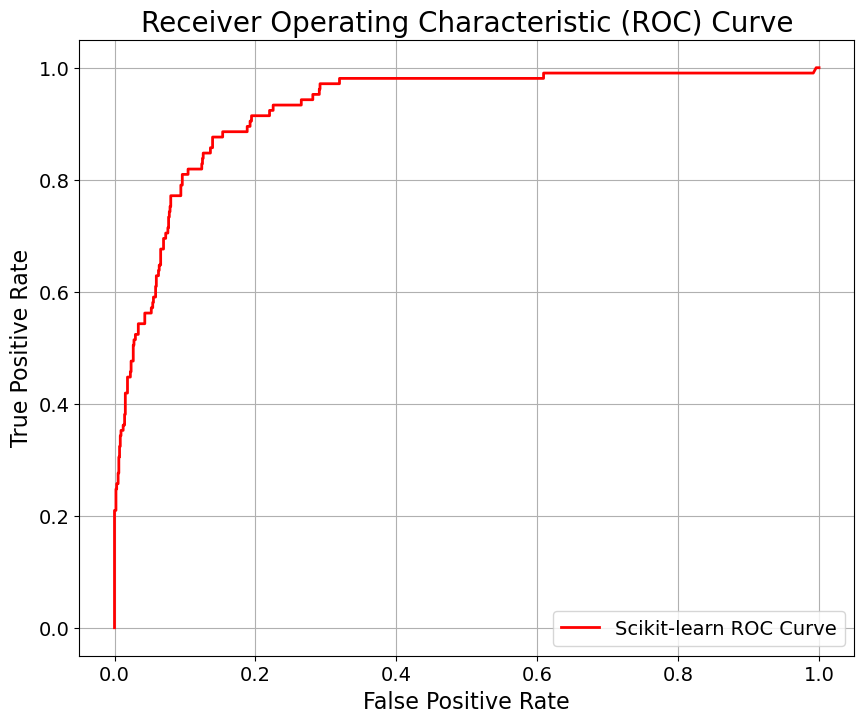

In [94]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r-', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [95]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9278646975678706)

In [ ]:
df = df.merge(train, how='left', on='Provider')

In [ ]:
df

,Provider,IPReimbursmentTotal,PotentialFraud
0,PRV51001,97000,No
1,PRV51003,573000,Yes
2,PRV51007,19000,No
3,PRV51008,25000,No
4,PRV51011,5000,No
...,...,...,...
2087,PRV57719,76000,No
2088,PRV57728,6000,No
2089,PRV57729,107000,No
2090,PRV57732,76000,No


In [ ]:
df['PotentialFraud'] = df['PotentialFraud'].map({'Yes': 1, 'No': 0})
df

,Provider,IPReimbursmentTotal,PotentialFraud
0,PRV51001,97000,0
1,PRV51003,573000,1
2,PRV51007,19000,0
3,PRV51008,25000,0
4,PRV51011,5000,0
...,...,...,...
2087,PRV57719,76000,0
2088,PRV57728,6000,0
2089,PRV57729,107000,0
2090,PRV57732,76000,0


In [ ]:
# feature total amount reimbursed by by the insurance per provider:
X = df[['IPReimbursmentTotal']]
X


,IPReimbursmentTotal
0,97000
1,573000
2,19000
3,25000
4,5000
...,...
2087,76000
2088,6000
2089,107000
2090,76000


In [ ]:
# target value (True or False), when 1 == Yes, and 0 == No.
y = df['PotentialFraud']
y

0       0
1       1
2       0
3       0
4       0
       ..
2087    0
2088    0
2089    0
2090    0
2091    0
Name: PotentialFraud, Length: 2092, dtype: int64

In [ ]:
# 1. Split the data: 80% for training, 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [ ]:
# 2. Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 3. Fit the model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# 4. Make prediction on the test 
y_pred = model.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

Confusion Matrix:
[[310  23]
 [ 53  33]]


In [ ]:
from sklearn.metrics import  precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precicion = precision_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
print(f'Accuracy: {accuracy:.2}')
print(f'precision: {precicion:.2}')
print(f'recall: {recall:.2}')
print(f'f1 score: {f1:.2}')

Accuracy: 0.82
precision: 0.59
recall: 0.38
f1 score: 0.46


In [ ]:
X_test

array([[-1.20438862e-01],
       [ 3.51224772e-01],
       [-5.05359760e-01],
       [-2.85792206e-01],
       [-3.69824232e-01],
       [-2.29138355e-01],
       [-4.53856259e-01],
       [-5.08070470e-01],
       [-5.24334733e-01],
       [-4.97227628e-01],
       [-3.75245654e-01],
       [-4.29459864e-01],
       [-3.75245654e-01],
       [-3.09854144e-02],
       [-4.53856259e-01],
       [-4.83674075e-01],
       [-4.64699101e-01],
       [-4.86384786e-01],
       [ 1.81500847e+00],
       [-4.99938339e-01],
       [ 4.16823967e-01],
       [-2.72238653e-01],
       [-2.55974390e-01],
       [-4.34881285e-01],
       [-4.94516917e-01],
       [-4.69786067e-02],
       [-2.39710126e-01],
       [-4.43013417e-01],
       [-3.96931338e-01],
       [-6.62246515e-02],
       [-2.61341596e-01],
       [-1.83598418e-01],
       [-4.32170575e-01],
       [-3.34584995e-01],
       [ 9.04209723e-01],
       [-5.24334733e-01],
       [-5.18913312e-01],
       [-5.05359760e-01],
       [-5.1

### loooking for a better threshold to find better f1 score:

In [ ]:
# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
precicions, recalls, thresholds = precision_recall_curve(y_test, y_pred)

f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 1


In [ ]:
# apply the new best threshold to the predicted probabilities
y_pred_custom = (y_proba >= best_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[333   0]
 [ 86   0]]


Accuracy: 0.82
precision: 0.59
recall: 0.38
f1 score: 0.46
